In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
tf.set_random_seed(55)
np.random.seed(55)

In [3]:
class LSTMcell(object):
    """
    create parameters and step function
    """
    def __init__(self, incoming, D_input, D_cell, initializer,
                 f_bias=1.0, L2=False, h_act=tf.tanh, 
                 init_h=None, init_c=None):
        
        # var
        self.incoming = incoming
        self.D_input = D_input
        self.D_cell = D_cell
        self.initializer = initializer
        self.f_bias = f_bias
        self.h_act = h_act
        self.type = 'lstm'
        
        if init_h is None and init_c is None:
            # If init_h and init_c are not provided, initialize them
            # the shape of init_h and init_c is [n_samples, D_cell]
            self.init_h = tf.matmul(self.incoming[0,:,:], tf.zeros([self.D_input, self.D_cell]))
            self.init_c = self.init_h
            self.previous = tf.stack([self.init_h, self.init_c])
            
        # parameters, each of which has W_x W_h b_f
        self.igate = self.Gate()
        self.fgate = self.Gate(bias = f_bias)
        self.ogate = self.Gate()
        self.cell = self.Gate()
        
        # to speed up computation. W_x has the shape of [D_input, 4*D_cell]
        self.W_x = tf.concat(values=[self.igate[0], self.fgate[0], self.ogate[0], self.cell[0]], axis=1)
        self.W_h = tf.concat(values=[self.igate[1], self.fgate[1], self.ogate[1], self.cell[1]], axis=1)
        self.b = tf.concat(values=[self.igate[2], self.fgate[2], self.ogate[2], self.cell[2]], axis=0)
        
        if L2:
            self.L2_loss = tf.nn.l2_loss(self.W_x) + tf.nn.l2_loss(self.W_h)
            
    def Gate(self, bias = 0.001):
        # Since we will use gate multiple times, let's code a class for reusing
        Wx = self.initializer([self.D_input, self.D_cell])
        Wh = self.initializer([self.D_cell, self.D_cell])
        b  = tf.Variable(tf.constant(bias, shape=[self.D_cell]),trainable=True) 
        return Wx, Wh, b

    def Slice_W(self, x, n):
        # split W's after computing
        return x[:, n*self.D_cell:(n+1)*self.D_cell]  
    
    def Step(self, previous_h_c_tuple, current_x):
        
        # to split hidden state and cell
        prev_h, prev_c = tf.unstack(previous_h_c_tuple)
        
        # computing all gates
        gates = tf.matmul(current_x, self.W_x) + tf.matmul(prev_h, self.W_h) + self.b
        
        # computing
        # input gate
        i = tf.sigmoid(self.Slice_W(gates, 0))
        # forget Gate
        f = tf.sigmoid(self.Slice_W(gates, 1))
        # output Gate
        o = tf.sigmoid(self.Slice_W(gates, 2))
        # new cell info
        c = tf.tanh(self.Slice_W(gates, 3))
        # current cell 
        current_c = f*prev_c + i*c
        # current hidden state
        current_h = o*self.h_act(current_c)

        return tf.stack([current_h, current_c])

In [4]:
class GRUcell(object):
    """
    create parameters and step function
    """
    def __init__(self, incoming, D_input, D_cell, initializer, L2=False, init_h=None):
        
        # var
        self.incoming = incoming
        self.D_input = D_input
        self.D_cell = D_cell
        self.initializer = initializer
        self.type = 'gru'

        if init_h is None:
            # If init_h is not provided, initialize it
            # the shape of init_h is [n_samples, D_cell]
            self.init_h = tf.matmul(self.incoming[0,:,:], tf.zeros([self.D_input, self.D_cell]))
            self.previous = self.init_h
            
        # parameters, each of which has W_x W_h b_f
        self.rgate = self.Gate()
        self.ugate = self.Gate()
        self.cell = self.Gate()
        
        # to speed up computation. W_x has the shape of [D_input, 3*D_cell]
        self.W_x = tf.concat(values=[self.rgate[0], self.ugate[0], self.cell[0]], axis=1)
        self.W_h = tf.concat(values=[self.rgate[1], self.ugate[1], self.cell[1]], axis=1)
        self.b = tf.concat(values=[self.rgate[2], self.ugate[2], self.cell[2]], axis=0)
        
        if L2:
            self.L2_loss = tf.nn.l2_loss(self.W_x) + tf.nn.l2_loss(self.W_h)
            
    def Gate(self, bias = 0.001):
        # Since we will use gate multiple times, let's code a class for reusing
        Wx = self.initializer([self.D_input, self.D_cell])
        Wh = self.initializer([self.D_cell, self.D_cell])
        b  = tf.Variable(tf.constant(bias, shape=[self.D_cell]),trainable=True) 
        return Wx, Wh, b
    
    def Slice_W(self, x, n):
        # split W's after computing
        return x[:, n*self.D_cell:(n+1)*self.D_cell]  
    
    def Step(self, prev_h, current_x):
        
        Wx = tf.matmul(current_x, self.W_x) + self.b
        Wh = tf.matmul(prev_h, self.W_h)
        
        r = tf.sigmoid(self.Slice_W(Wx, 0) + self.Slice_W(Wh, 0))
        u = tf.sigmoid(self.Slice_W(Wx, 1) + self.Slice_W(Wh, 1))
        
        c = tf.tanh(self.Slice_W(Wx, 2) + r*self.Slice_W(Wh, 2))
                    
        current_h = (1-u)*prev_h + u*c
        
        return current_h

In [5]:
def RNN(cell, cell_b=None, merge='sum'):
    """
    Note that the input shape should be [n_steps, n_sample, D_output],
    and the output shape will also be [n_steps, n_sample, D_output].
    If the original data has a shape of [n_sample, n_steps, D_input],
    use 'inputs_T = tf.transpose(inputs, perm=[1,0,2])'.
    """

    # forward rnn loop
    hstates = tf.scan(fn = cell.Step,
                    elems = cell.incoming,
                    initializer = cell.previous,
                    name = 'hstates')
    if cell.type == 'lstm':
        hstates = hstates[:,0,:,:]
    # reverse the input sequence
    if cell_b is not None:
        incoming_b = tf.reverse(cell.incoming, axis=[0])
    
    # backward rnn loop
        b_hstates_rev = tf.scan(fn = cell_b.Step,
                    elems = incoming_b,
                    initializer = cell_b.previous,
                    name = 'b_hstates')
        if cell_b.type == 'lstm':
            b_hstates_rev = b_hstates_rev[:,0,:,:]
            
        b_hstates = tf.reverse(b_hstates_rev, axis=[0])
    
        if merge == 'sum':
            hstates = hstates + b_hstates
        else:
            hstates = tf.concat(values=[hstates, b_hstates], axis=2)
    return hstates

In [6]:
def weight_init(shape):
    initial = tf.random_uniform(shape,minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]), maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
    return tf.Variable(initial,trainable=True)
def zero_init(shape):
    initial = tf.Variable(tf.zeros(shape))
    return tf.Variable(initial,trainable=True)
def orthogonal_initializer(shape,scale = 1.0):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape) #this needs to be corrected to float32
    return tf.Variable(scale * q[:shape[0], :shape[1]], dtype=tf.float32,trainable=True)
def bias_init(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial,trainable=True)
def shufflelists(data):
    ri=np.random.permutation(len(data))
    data=[data[i] for i in ri]
    return data
def Standardize(seq):
    #subtract mean
    centerized=seq-np.mean(seq, axis = 0)
    #divide standard deviation
    normalized=centerized/np.std(centerized, axis = 0)
    return normalized
mfc=np.load('X.npy',encoding='latin1')
art=np.load('Y.npy',encoding='latin1')
totalsamples=len(mfc)
vali_size=0.2
def data_prer(X, Y):
    D_input=X[0].shape[1]
    D_output=24
    data=[]
    for x,y in zip(X,Y):
        data.append([Standardize(x).reshape((1,-1,D_input)).astype("float32"),
                     Standardize(y).astype("float32")])
    return data
data=data_prer(mfc, art)
train=data[int(totalsamples*vali_size):]
test=data[:int(totalsamples*vali_size)]
print('num of train sequences:%s' %len(train))
print('num of test sequences:%s' %len(test))
print('shape of inputs:' ,test[0][0].shape)
print('shape of labels:' ,test[0][1].shape)

num of train sequences:83
num of test sequences:20
shape of inputs: (1, 886, 39)
shape of labels: (886, 24)


In [7]:
D_input = 39
D_label = 24
learning_rate = 7e-5
num_units=1024
L2_penalty = 1e-4
inputs = tf.placeholder(tf.float32, [None, None, D_input], name="inputs")
labels = tf.placeholder(tf.float32, [None, D_label], name="labels")
drop_keep_rate = tf.placeholder(tf.float32, name="dropout_keep")

n_steps = tf.shape(inputs)[1]
n_samples = tf.shape(inputs)[0]

# reshape for dense layer:  [n_samples, n_steps, D_input] to [n_samples*n_steps, D_input]
# first layer
re1 = tf.reshape(inputs, [-1, D_input])
Wf0 = weight_init([D_input, num_units])
bf0 = bias_init([num_units])
h1 = tf.nn.relu(tf.matmul(re1, Wf0) + bf0)
# dropout
h1d = tf.nn.dropout(h1, drop_keep_rate)
# second layer
Wf1 = weight_init([num_units, num_units])
bf1 = bias_init([num_units])
h2 = tf.nn.relu(tf.matmul(h1d, Wf1) + bf1)
# dropout
h2d = tf.nn.dropout(h2, drop_keep_rate)
# reshape for lstm: [n_samples*n_steps, D_input] to [n_samples, n_steps, D_input]
re2 = tf.reshape(h2d, [n_samples,n_steps, num_units])

inputs_T = tf.transpose(re2, perm=[1,0,2])

# lstm
#rnn_fcell = LSTMcell(inputs_T, num_units, num_units, zero_init, f_bias=1.0)
#rnn_bcell = LSTMcell(inputs_T, num_units, num_units, zero_init, f_bias=1.0)
rnn_fcell = GRUcell(inputs_T, num_units, num_units, orthogonal_initializer)
rnn_bcell = GRUcell(inputs_T, num_units, num_units, orthogonal_initializer)
rnn0 = RNN(rnn_fcell, rnn_bcell)

#cell = Bi_LSTM_cell(inputs_T, num_units, num_units, 1)
#rnn0 = cell.get_states()

# reshape for output layer
rnn1 = tf.reshape(rnn0, [-1, num_units])

rnn2 = tf.nn.dropout(rnn1, drop_keep_rate)

# third layer
W0 = weight_init([num_units, num_units])
b0 = bias_init([num_units])
rnn3 = tf.nn.relu(tf.matmul(rnn2, W0) + b0)
rnn4 = tf.nn.dropout(rnn3, drop_keep_rate)
# fourth layer
W1 = weight_init([num_units, num_units])
b1 = bias_init([num_units])
rnn5 = tf.nn.relu(tf.matmul(rnn4, W1) + b1)
rnn6 = tf.nn.dropout(rnn5, drop_keep_rate)

# output layer
W = weight_init([num_units, D_label])
b = bias_init([D_label])
output = tf.matmul(rnn6, W) + b

loss=tf.reduce_mean((output-labels)**2)
L2_total = tf.nn.l2_loss(Wf0) + tf.nn.l2_loss(Wf1)+ tf.nn.l2_loss(W0) + tf.nn.l2_loss(W1) + tf.nn.l2_loss(W)#+ rnn_fcell.L2_loss + rnn_bcell.L2_loss 

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss + L2_penalty*L2_total)

In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
# 训练并记录
def train_epoch(EPOCH):
    for k in range(EPOCH):
        train0=shufflelists(train)
        for i in range(len(train)):
            sess.run(train_step,feed_dict={inputs:train0[i][0],labels:train0[i][1],drop_keep_rate:0.7})
        tl=0
        dl=0
        for i in range(len(test)):
            dl+=sess.run(loss,feed_dict={inputs:test[i][0],labels:test[i][1],drop_keep_rate:1.0})
        for i in range(len(train)):
            tl+=sess.run(loss,feed_dict={inputs:train[i][0],labels:train[i][1],drop_keep_rate:1.0})
        print(k,'train:',round(tl/83,3),'test:',round(dl/20,3))

In [10]:
t0 = time.time()
train_epoch(100)
t1 = time.time()
print(" %f seconds" % round((t1 - t0),2))

0 train: 0.8 test: 0.816
1 train: 0.695 test: 0.72
2 train: 0.598 test: 0.631
3 train: 0.525 test: 0.558
4 train: 0.463 test: 0.499
5 train: 0.428 test: 0.466
6 train: 0.384 test: 0.436
7 train: 0.355 test: 0.409
8 train: 0.336 test: 0.398
9 train: 0.315 test: 0.397
10 train: 0.29 test: 0.374
11 train: 0.268 test: 0.359
12 train: 0.254 test: 0.353
13 train: 0.247 test: 0.356
14 train: 0.241 test: 0.349
15 train: 0.227 test: 0.34
16 train: 0.212 test: 0.328
17 train: 0.207 test: 0.33
18 train: 0.204 test: 0.332
19 train: 0.196 test: 0.326
20 train: 0.189 test: 0.321
21 train: 0.183 test: 0.314
22 train: 0.186 test: 0.323
23 train: 0.172 test: 0.312
24 train: 0.174 test: 0.318
25 train: 0.166 test: 0.311
26 train: 0.16 test: 0.302
27 train: 0.156 test: 0.301
28 train: 0.159 test: 0.31
29 train: 0.155 test: 0.302
30 train: 0.158 test: 0.303
31 train: 0.141 test: 0.291
32 train: 0.149 test: 0.303
33 train: 0.143 test: 0.299
34 train: 0.142 test: 0.296
35 train: 0.144 test: 0.298
36 train: 

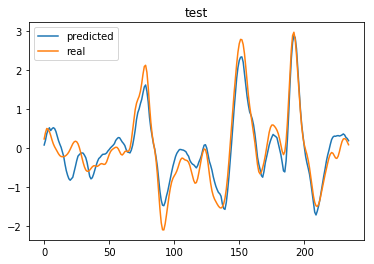

In [11]:
pY=sess.run(output,feed_dict={inputs:test[10][0],drop_keep_rate:1.0})
plt.plot(pY[:,8])
plt.plot(test[10][1][:,8])
plt.title('test')
plt.legend(['predicted','real'])

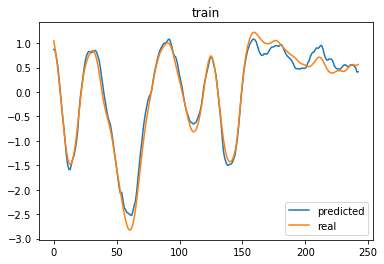

In [12]:
pY=sess.run(output,feed_dict={inputs:train[1][0],drop_keep_rate:1.0})
plt.plot(pY[:,6])
plt.plot(train[1][1][:,6])
plt.title('train')
plt.legend(['predicted','real'])